In [5]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from PIL import Image
import numpy as np
import pandas as pd

In [2]:
from pathlib import Path

## Dataset

The dataset is a set of audio recordings from cats. Samples are short clips (1-2 seconds) grouped in three classes:
- brushing the cat
- cat is in unfamiliar environment (discomfort)
- waiting for food

Source: https://zenodo.org/record/4008297 <br>
Paper: https://air.unimi.it/handle/2434/811133

In [3]:
dataset_dir = Path('/home/flo/projects/data-playground/data/catmeows/wav')
dataset_png = dataset_dir.parent / 'png'

## Dataset distribution

In [94]:
df = pd.DataFrame({'filename': [f.name for f in dataset_dir.glob('*.wav')]})
df['cat_id'] = df.filename.str.slice(2, 7)
df['situation'] = df.filename.str.get(0).map({'B': 'brushing', 'F': 'food', 'I': 'isolation'})
df['sex'] = df.filename.str.get(11).map({'F': 'female', 'M': 'male'})
df['breed'] = df.filename.str.get(8).map({'M': 'maine_coon', 'E': 'european_shorthair'})
df

,filename,cat_id,situation,sex,breed
0,B_JJX01_MC_FN_SIM01_103.wav,JJX01,brushing,female,maine_coon
1,B_ANI01_MC_FN_SIM01_302.wav,ANI01,brushing,female,maine_coon
2,I_DAK01_MC_FN_SIM01_106.wav,DAK01,isolation,female,maine_coon
3,I_MEG01_MC_FI_SIM01_104.wav,MEG01,isolation,female,maine_coon
4,I_CAN01_EU_FN_GIA01_105.wav,CAN01,isolation,female,european_shorthair
...,...,...,...,...,...
435,I_BLE01_EU_FN_DEL01_210.wav,BLE01,isolation,female,european_shorthair
436,F_WHO01_MC_FI_SIM01_301.wav,WHO01,food,female,maine_coon
437,F_WHO01_MC_FI_SIM01_302.wav,WHO01,food,female,maine_coon
438,F_IND01_EU_FN_ELI01_301.wav,IND01,food,female,european_shorthair


In [50]:
df.cat_id.value_counts()

CAN01    54
BLE01    48
DAK01    40
WHO01    39
MAG01    27
SPI01    27
MAT01    26
BAC01    25
IND01    21
CLE01    20
BRA01    19
BRI01    15
MIN01    14
NUL01    14
MEG01    14
ANI01    10
JJX01     7
REG01     5
TIG01     5
LEO01     5
NIG01     5
Name: cat_id, dtype: int64

<AxesSubplot:title={'center':'Recordings per individual cat'}>

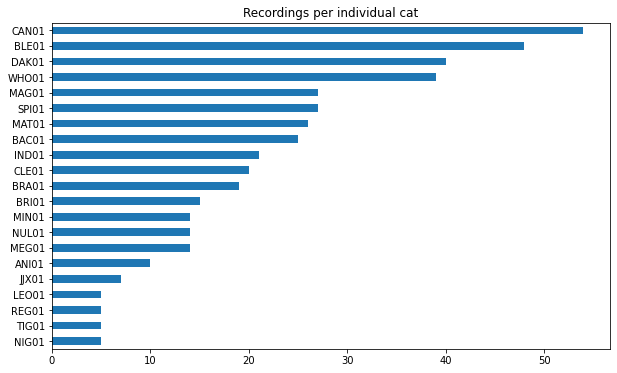

In [63]:
df.cat_id.value_counts().sort_values().plot.barh(title="Recordings per individual cat", figsize=(10, 6))

In [42]:
df.situation.value_counts()

isolation    221
brushing     127
food          92
Name: situation, dtype: int64

<AxesSubplot:title={'center':'Recordings per situation'}>

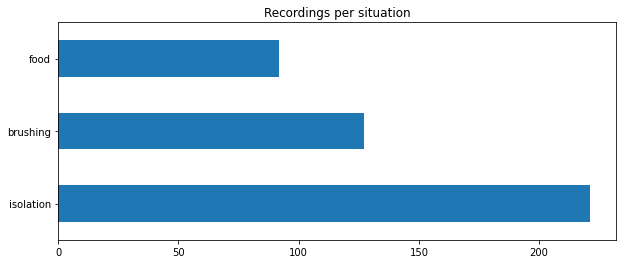

In [64]:
df.situation.value_counts().plot.barh(title='Recordings per situation', figsize=(10, 4))

In [53]:
df.sex.value_counts()

female    345
male       95
Name: sex, dtype: int64

<AxesSubplot:title={'center':'Recordings per sex'}>

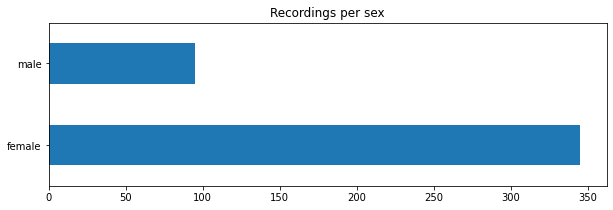

In [60]:
df.sex.value_counts().plot.barh(title='Recordings per sex', figsize=(10, 3))

In [58]:
df.breed.value_counts()

european_shorthair    252
maine_coon            188
Name: breed, dtype: int64

<AxesSubplot:title={'center':'Recordings per breed'}>

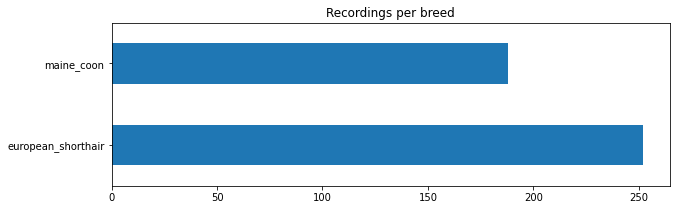

In [59]:
df.breed.value_counts().plot.barh(title='Recordings per breed', figsize=(10, 3))

## Prepare clean datasplit

We could split our data randomly into train and validation data.
However, that could provide the classifier some opportunity of cheating
because the same cat could appear in both splits of the data.
Instead, we want to cleanly separate the individuals into train and validation split.
We will keep it to two splits and not have an additional test split.

In [95]:

df_split =  pd.DataFrame({
    'cat_id': df.cat_id.value_counts().sort_values(),  # sort individuals by how often they appear in the data
    'is_valid': False
})
df_split.loc[1::5, 'is_valid'] = True  # every 5th individual will be in validation, so roughly 20%
df_split['cat_id'] = df_split.index
df_split.reset_index(drop=True, inplace=True)
df_split

/home/flo/miniconda3/envs/practice-ml/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  """


,cat_id,is_valid
0,NIG01,False
1,TIG01,True
2,REG01,False
3,LEO01,False
4,JJX01,False
5,ANI01,False
6,MEG01,True
7,NUL01,False
8,MIN01,False
9,BRI01,False


In [96]:
df = df.merge(df_split, on='cat_id')
df

,filename,cat_id,situation,sex,breed,is_valid
0,B_JJX01_MC_FN_SIM01_103.wav,JJX01,brushing,female,maine_coon,False
1,B_JJX01_MC_FN_SIM01_202.wav,JJX01,brushing,female,maine_coon,False
2,B_JJX01_MC_FN_SIM01_301.wav,JJX01,brushing,female,maine_coon,False
3,B_JJX01_MC_FN_SIM01_201.wav,JJX01,brushing,female,maine_coon,False
4,B_JJX01_MC_FN_SIM01_102.wav,JJX01,brushing,female,maine_coon,False
...,...,...,...,...,...,...
435,B_NIG01_MC_MN_SIM01_101.wav,NIG01,brushing,male,maine_coon,False
436,B_NIG01_MC_MN_SIM01_201.wav,NIG01,brushing,male,maine_coon,False
437,B_NIG01_MC_MN_SIM01_103.wav,NIG01,brushing,male,maine_coon,False
438,I_NIG01_MC_MN_SIM01_201.wav,NIG01,isolation,male,maine_coon,False


In [98]:
# 15% for validation
df.is_valid.value_counts()

False    374
True      66
Name: is_valid, dtype: int64

Prepare list of numerical index numbers of all samples in the validation set.

In [120]:
valid_idx = np.where(df.is_valid)[0]
valid_idx

array([ 57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386,
       387, 388, 389, 390, 391, 392, 393, 394, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434])

## Convert audio samples into images of spectograms

In [99]:
from scipy.io import wavfile
from scipy import signal
import numpy as np

# source: https://stackoverflow.com/questions/47954034/plotting-spectrogram-in-audio-analysis/47954408
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [100]:
def wav_to_png(path_wav, overwrite=False):
    path_png = dataset_png / f'{path_wav.stem}.png'
    
    if path_png.exists() and not overwrite:
        return path_png

    # read wave file
    sample_rate, audio = wavfile.read(path_wav)

    # turn audio into spectogram
    freqs, times, specgram = log_specgram(audio, sample_rate)

    # bring into range 0..255
    specgram_normed = (specgram + abs(specgram.min())) / (abs(specgram.min()) + specgram.max())
    specgram_normed = (specgram_normed * 255).astype(np.uint8) 

    # save as image
    if write:
        data = Image.fromarray(specgram_normed)
        data.save(path_png)


In [101]:
paths_wav = list(dataset_dir.glob('*.wav'))
paths_png = [
    wav_to_png(path_wav)
    for path_wav
    in paths_wav
]

## Look at some example spectrograms

In [102]:
import IPython

def show_sample(idx):
    IPython.display.display(IPython.display.Audio(paths_wav[idx]))
    IPython.display.display(IPython.display.Image(paths_png[idx]))

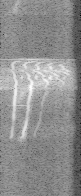

In [103]:
show_sample(24)

## Inspect (some) shapes

In [107]:
for idx in range(5):
    print(np.array(Image.open(paths_png[idx])).shape)

(140, 81)
(125, 81)
(150, 81)
(155, 81)
(161, 81)


## DataLoader

In [108]:
import fastbook
fastbook.setup_book()
from fastbook import *

In [11]:
# from torchvision import transforms
# transforms.Pad

This is what a loaded image looks like (when loaded as PILImageBW, we have no color channels)

In [109]:
np.array(PILImage.create(paths_png[0])).shape

(140, 81, 3)

In [110]:
np.array(PILImageBW.create(paths_png[0])).shape

(140, 81)

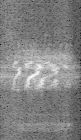

In [111]:
PILImageBW.create(paths_png[0])

Label for each sample can be extracted from its file name.
According to the authors:

Naming conventions follow the pattern C_NNNNN_BB_SS_OOOOO_RXX, which has to be exploded as follows:

- C = emission context (values: B = brushing; F = waiting for food; I: isolation in an unfamiliar environment);
- NNNNN = cat’s unique ID;
- BB = breed (values: MC = Maine Coon; EU: European Shorthair);
- SS = sex (values: FI = female, intact; FN: female, neutered; MI: male, intact; MN: male, neutered);
- OOOOO = cat owner’s unique ID;
- R = recording session (values: 1, 2 or 3)
- XX = vocalization counter (values: 01..99)




In [127]:

label_dict_situation = {
    'B': 'brushing',
    'F': 'food',
    'I': 'isolation'
}
def label_func_situation(fname):
    # B = brushing; F = waiting for food; I: isolation in an unfamiliar environment
    return label_dict_situation[fname.name[0]]

def label_func_sex(fname):
    # returns M or F
    return fname.name[11].lower()

dict_breed = {'MC': "maine_coone", 'EU': 'european_shorthair'}
def label_func_breed(fname):
    return dict_breed[fname.name[8:10]]
    

def get_dataloaders(task, batch_size=128):
    label_func = {
        'situation': label_func_situation,
        'sex': label_func_sex,
        'breed': label_func_breed
    }[task]
    
    data = DataBlock(
        blocks=(ImageBlock(cls=PILImage), CategoryBlock),
        get_items=get_image_files,
#         splitter=RandomSplitter(),  # TODO: clean split so that same cats don't appear in both sets
        splitter=IndexSplitter(valid_idx),
        item_tfms=[CropPad(81)],
        batch_tfms=setup_aug_tfms([Brightness(), Contrast()]),  # TODO: experiment with more augmentation
        get_y=label_func, 
    )
    
    return data, data.dataloaders(dataset_png, bs=batch_size)
datablock, dls = get_dataloaders('sex')

In [128]:
# datablock.summary(dataset_png)

**Looking at first batch:**

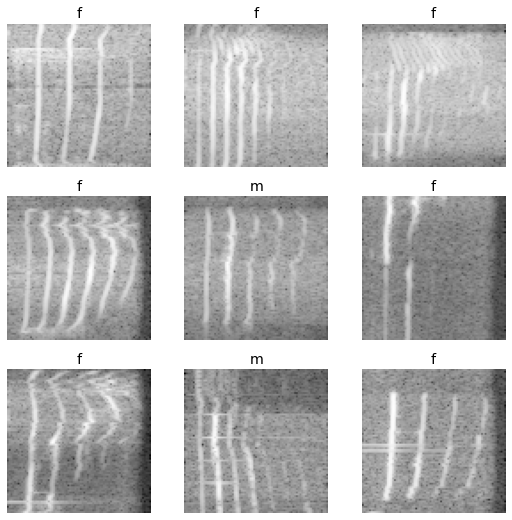

In [129]:
dls.show_batch()

fastai has also normalized the data to range 0..1 for us:

In [18]:
# one_sample.min().item(), one_sample.max().item()

In [19]:
# only works for single-channel
# plt.imshow(one_sample.squeeze(), cmap='gray', vmin=0, vmax=1)

In [20]:
# does this one look closer to what show_batch produces?
# plt.imshow((1./one_sample.squeeze()).log(), cmap='gray')

In [130]:
# how many classes?
dls.c

2

## ResNet: Determine cat's sex

In [131]:
def resnet(n_classes=3, pretrained=False):
    return create_cnn_model(models.resnet18, n_classes, pretrained)

In [134]:
def resnet_learner(callbacks=None, task='sex', pretrained=False):
    _, _dls = get_dataloaders(task)
    return Learner(
        _dls,
        resnet(n_classes=_dls.c, pretrained=pretrained),
        metrics=accuracy,
        cbs=callbacks
    )

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=0.002511886414140463)

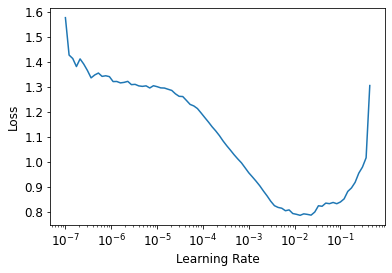

In [135]:
learn_resnet_lr = resnet_learner(pretrained=True)
learn_resnet_lr.lr_find()

In [136]:
learn_resnet = resnet_learner(ActivationStats(with_hist=True), pretrained=True)

In [137]:
learn_resnet.fit_one_cycle(20, 0.0025)

/home/flo/miniconda3/envs/practice-ml/lib/python3.7/site-packages/fastai/callback/core.py:50: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,1.200614,0.475802,0.772727,00:02
1,1.076965,0.480368,0.818182,00:02
2,0.991696,0.845470,0.515152,00:02
3,0.932770,4.383357,0.181818,00:02
4,0.880005,8.172329,0.166667,00:02
5,0.882998,7.805351,0.181818,00:02
6,0.805710,4.081443,0.318182,00:02
7,0.744211,4.322939,0.333333,00:02
8,0.671487,5.416689,0.318182,00:02
9,0.611435,0.623816,0.863636,00:02


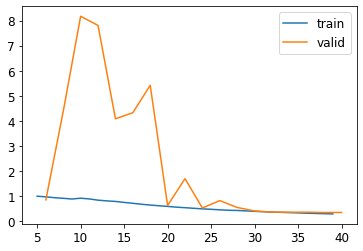

In [138]:
learn_resnet.recorder.plot_loss()

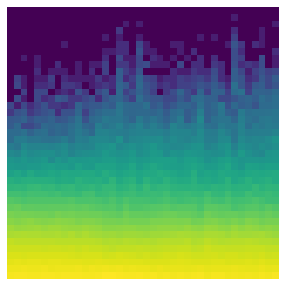

In [139]:
learn_resnet.activation_stats.color_dim(-2)

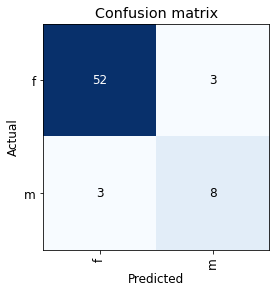

In [140]:
interpretation = ClassificationInterpretation.from_learner(learn_resnet)
interpretation.plot_confusion_matrix()

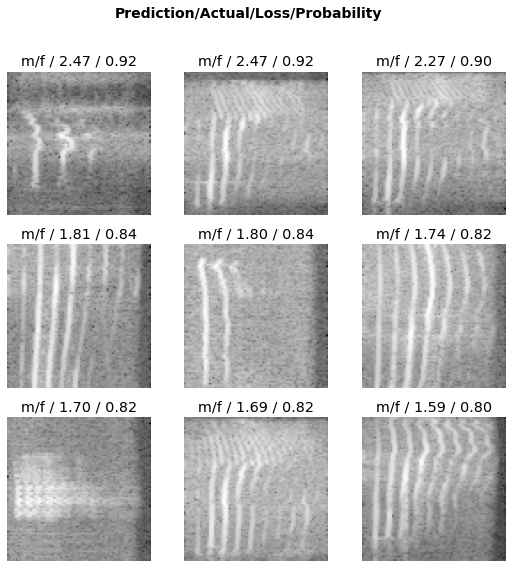

In [30]:
interpretation.plot_top_losses(9)

## ResNet: Which situation (or mood?) is the cat in (3 classes)

In [178]:
learn_situation = resnet_learner(task='situation', pretrained=True)

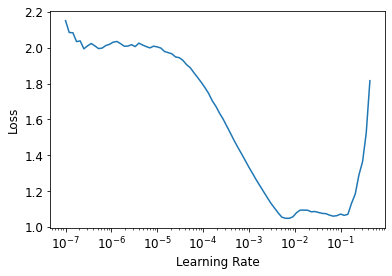

In [179]:
_, lr_steep = learn_situation.lr_find()

In [180]:
print(lr_steep)
learn_situation.fit_one_cycle(50, lr_steep)

0.00013182566908653826


epoch,train_loss,valid_loss,accuracy,time
0,1.987833,1.222635,0.393939,00:00
1,2.159333,1.205281,0.393939,00:00
2,2.117699,1.221973,0.333333,00:00
3,2.025134,1.262651,0.287879,00:00
4,1.948166,1.273165,0.287879,00:00
5,1.842500,1.272850,0.303030,00:00
6,1.769115,1.255963,0.363636,00:00
7,1.662445,1.237832,0.378788,00:00
8,1.587365,1.229841,0.393939,00:00
9,1.497358,1.224469,0.393939,00:00


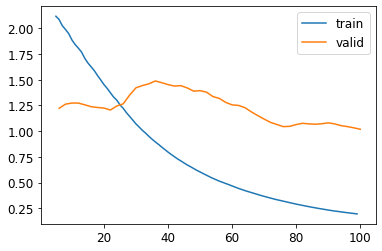

In [181]:
learn_situation.recorder.plot_loss()

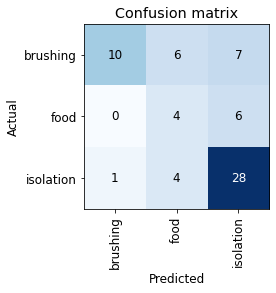

In [182]:
interpretation = ClassificationInterpretation.from_learner(learn_situation)
interpretation.plot_confusion_matrix()

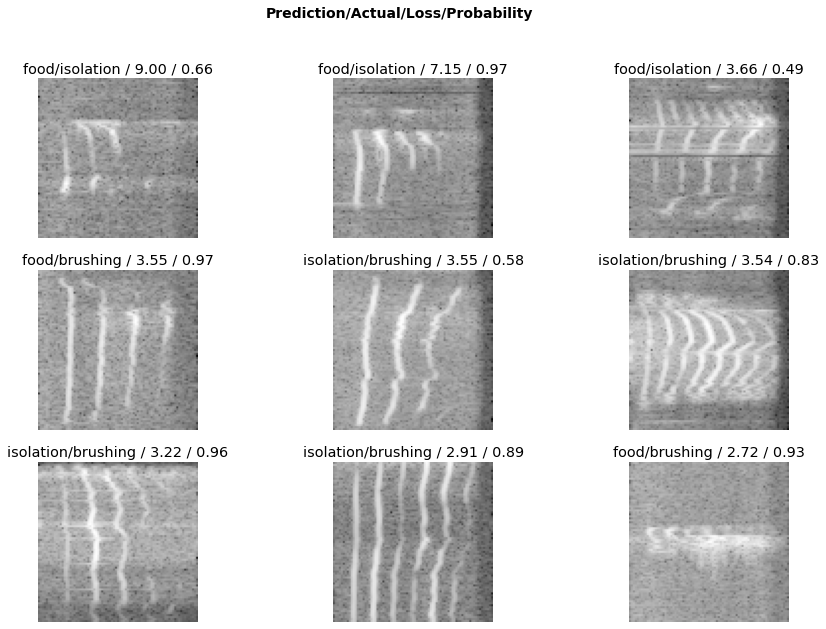

In [183]:
interpretation.plot_top_losses(9, figsize=(15, 10))

## ResNet: Can we tell the breed from the audio? (2 classes)

In [151]:
learn_breed = resnet_learner(task='breed', pretrained=True)

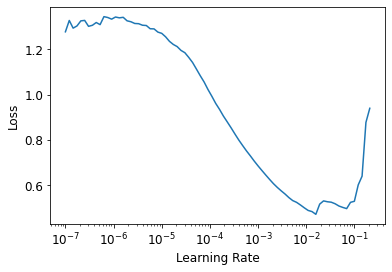

In [152]:
_, lr_steep = learn_breed.lr_find()

In [153]:
learn_breed.fit_one_cycle(30, lr_steep)

epoch,train_loss,valid_loss,accuracy,time
0,1.291014,0.955244,0.500000,00:00
1,1.270691,0.867179,0.530303,00:00
2,1.212147,0.790240,0.560606,00:00
3,1.132754,0.724076,0.575758,00:00
4,1.063818,0.622234,0.651515,00:00
5,0.986177,0.510012,0.742424,00:00
6,0.902753,0.446789,0.803030,00:00
7,0.808171,0.408663,0.803030,00:00
8,0.726056,0.377681,0.818182,00:00
9,0.656433,0.354182,0.818182,00:00


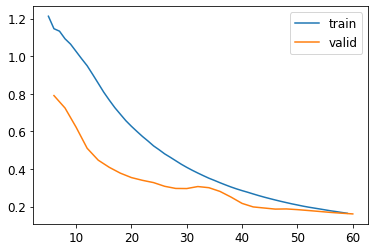

In [154]:
learn_breed.recorder.plot_loss()

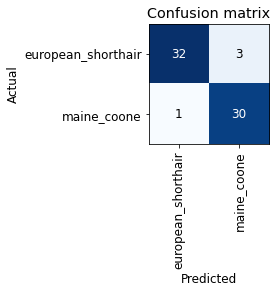

In [155]:
interpretation = ClassificationInterpretation.from_learner(learn_breed)
interpretation.plot_confusion_matrix()

## Ideas for improvement

Experiment with better data augmentation. Challenge: It can't just be any typical image augmentation, it should be sensible for the audio data. For example: Taking random crops along time axis makes sense. Taking crops from higher and lower in the spectrum: Maybe not too much, because then the absolute frequency information is lost.

## Custom ConvNet model (WIP)

In [184]:
in_shape = (81, 81)  # time, frequencies, channels
n_classes = 3

def simple_net(n_channels=3):
    return nn.Sequential(
        nn.Conv2d(n_channels, 16, 5, stride=2),  # -> (8, ?, ?)
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout(),
        nn.Conv2d(16, 32, 3, stride=2),  # -> (16, ?, ?)
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Dropout(),
        nn.Conv2d(32, 32, 3, stride=2), # -> (32, 9, 9)
        nn.BatchNorm2d(32),
        nn.Flatten(),
        nn.Linear(32*9*9, 256),
        nn.ReLU(),
        nn.Linear(256, n_classes),
    )

net = simple_net()
print(net)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.5, inplace=False)
  (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=2592, out_features=256, bias=True)
  (12): ReLU()
  (13): Linear(in_features=256, out_features=3, bias=True)
)


In [185]:
sample = torch.randn(4, 3, 81, 81)
net(sample).shape

torch.Size([4, 3])

In [186]:
_, dls = get_dataloaders(task='situation')
learn_simplenet = Learner(
    dls,
    simple_net(),
#         loss_func=F.cross_entropy,  # <-- breaks confusion matrix for some reason
    metrics=accuracy,
    cbs=ActivationStats(with_hist=True)
)

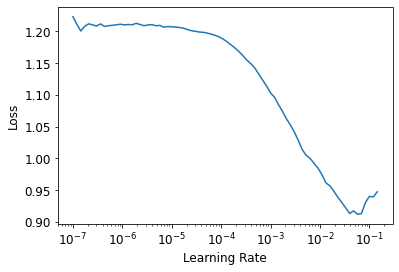

In [187]:
_, lr_steep = learn_simplenet.lr_find()

In [188]:
learn_simplenet.fit_one_cycle(20, lr_steep)

epoch,train_loss,valid_loss,accuracy,time
0,1.212338,1.093954,0.348485,00:00
1,1.161135,1.074898,0.500000,00:00
2,1.098212,1.041414,0.500000,00:00
3,1.029060,1.027391,0.500000,00:00
4,0.963947,1.004592,0.606061,00:00
5,0.907106,1.008583,0.621212,00:00
6,0.846505,1.138694,0.348485,00:00
7,0.817441,1.281267,0.348485,00:00
8,0.779928,0.891083,0.545455,00:00
9,0.744981,0.998821,0.469697,00:00


In [70]:
# def fit(epochs=20, lr=0.003):
#     learn = Learner(
#         dls,
#         simple_net(),
# #         loss_func=F.cross_entropy,
# #         loss_func=CrossEntropyLossFlat,
#         metrics=accuracy,
#         cbs=ActivationStats(with_hist=True)
#     )
#     learn.fit_one_cycle(epochs, lr)
#     return learn


# learn = fit(lr=lr_steep)

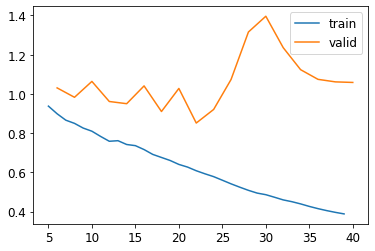

In [71]:
learn_simplenet.recorder.plot_loss()

In [64]:
learn.cbs

(#4) [TrainEvalCallback,Recorder,ProgressCallback,ActivationStats]

## Classification results

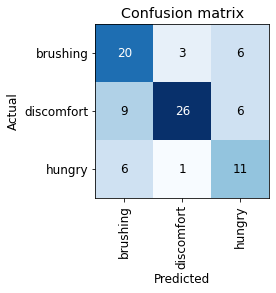

In [72]:
interpretation = ClassificationInterpretation.from_learner(learn_simplenet)
interpretation.plot_confusion_matrix()

### Activations on first layer

In [35]:
# learn.activation_stats.stats

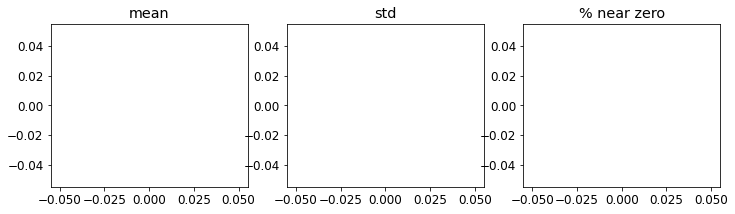

In [74]:
learn_simplenet.activation_stats.plot_layer_stats(0)

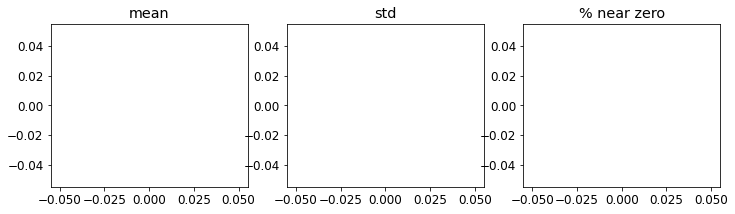

In [75]:
learn_simplenet.activation_stats.plot_layer_stats(-2)

In [76]:
learn_simplenet.activation_stats.color_dim(-2)

RuntimeError: stack expects a non-empty TensorList